# Erkennung von amerikanischer Zeichensprache

Dieses Projekt wurde bearbeitet von Kilian Lorenz und Tjark Gerken.

---

Der Inhalt umfasst die Erkennung amerikanischen Zeichen für Buchstaben, die keine Bewegungen beinhalten.
Diese sind A, B, C, D, E, F, G, H, I, K, L, M, N, O, P, Q, R, S, T, U, V, W, X und Y. Andere Zeichen sind derzeit nicht erkennbar.

Das Projekt basiert auf dem folgenden Datensatz:
https://www.kaggle.com/datasets/datamunge/sign-language-mnist

## Importieren der notwendigen Libraries

Das Projekt nutzt Keras zum Erstellen der Modelle. Notwendige andere Bibliotheken sind Matplotlib und Seaborn zum erstellen der Grafiken. Os, random, Pandas und numpy sind als Standard Bibliotheken ebenfalls notwendig.

## Importieren der Daten und Aufsetzen des Projekts
Die Daten werden aus dem Speicherort geladen

Standardmäßig wird das Modell nicht bei jedem Durchlauf neu trainiert, um einfachere Nutzbarkeit zu ermöglichen. Sollte es gewünscht sein kann die Variable Retrain auf True gesetzt werden und der Trainingsprozess wird erneut durchlaufen. Das Jupyter Notebook speichert die Modelle und benötigten Daten für die Grafiken in einem Ordner ab der standardmäßig "models" heißt ab, dieser Ort kann mit der Variable "cache_path" festgelegt werden.

Wenn der Cache Path nicht existiert oder einer der benötigten Dateien fehlt, wird die Variable retrain auf True gesetzt, dementsprechend wird der Trainingsprozess durchlaufen und die benötigten Daten generiert.

Es ist zum Empfehlen diese Einstellungen nicht zu verändern.




### Variable die steuert ob die Modelle neu trainiert werden sollen.

In [40]:
retrain = False

cache_path = "./models/"
plot_path =  "./output/"
model_name = "american_dataset.h5"
output_format = ".svg"

In [41]:
# Basic Packages
import random
import numpy as np
import os
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.models import Sequential
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

In [42]:
sns.axes_style("whitegrid")

training_history = "training_history.csv"

if not os.path.isdir(cache_path):
    os.mkdir(cache_path)

if not os.path.isdir(plot_path):
    os.mkdir(plot_path)

if not os.path.exists(cache_path + model_name) or not os.path.exists(cache_path + training_history):
    retrain = True

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = [20, 15]

train_df = pd.read_csv("data/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("data/sign_mnist_test/sign_mnist_test.csv")

# Exploration des Datensatzes

Es werden im Folgenden die Anzahl der Einträge, sowie die Verteilung dieser Einträge auf die unterschiedlichen Klassen beachtet.

In [43]:
classes= ["A","B","C","D","E","F","G","H","I","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y"]

train_num_samples = len(train_df)
test_num_samples = len(test_df)
print(f"{'=' * 10} Exploration of the Data Set {'=' * 10}")
print(f'Anzahl an Trainingsdaten: \t\t\t\t\t {train_num_samples} Einträge')
print(f'Anzahl an Testdaten: \t\t\t\t\t\t {test_num_samples} Einträge')
print(f"Durchschnittliche Einträge pro Buchstabe \t {round(train_df.groupby(by=['label'])['pixel1'].count().mean(),2)}")
print(f"{'=' * 10} Exploration of the Data Set {'=' * 10}")

========== Exploration of the Data Set ==========
Anzahl an Trainingsdaten: 					 27455 Einträge
Anzahl an Testdaten: 						 7172 Einträge
Durchschnittliche Einträge pro Buchstabe 	 1143.96
========== Exploration of the Data Set ==========


## Verteilung des Datensatzes

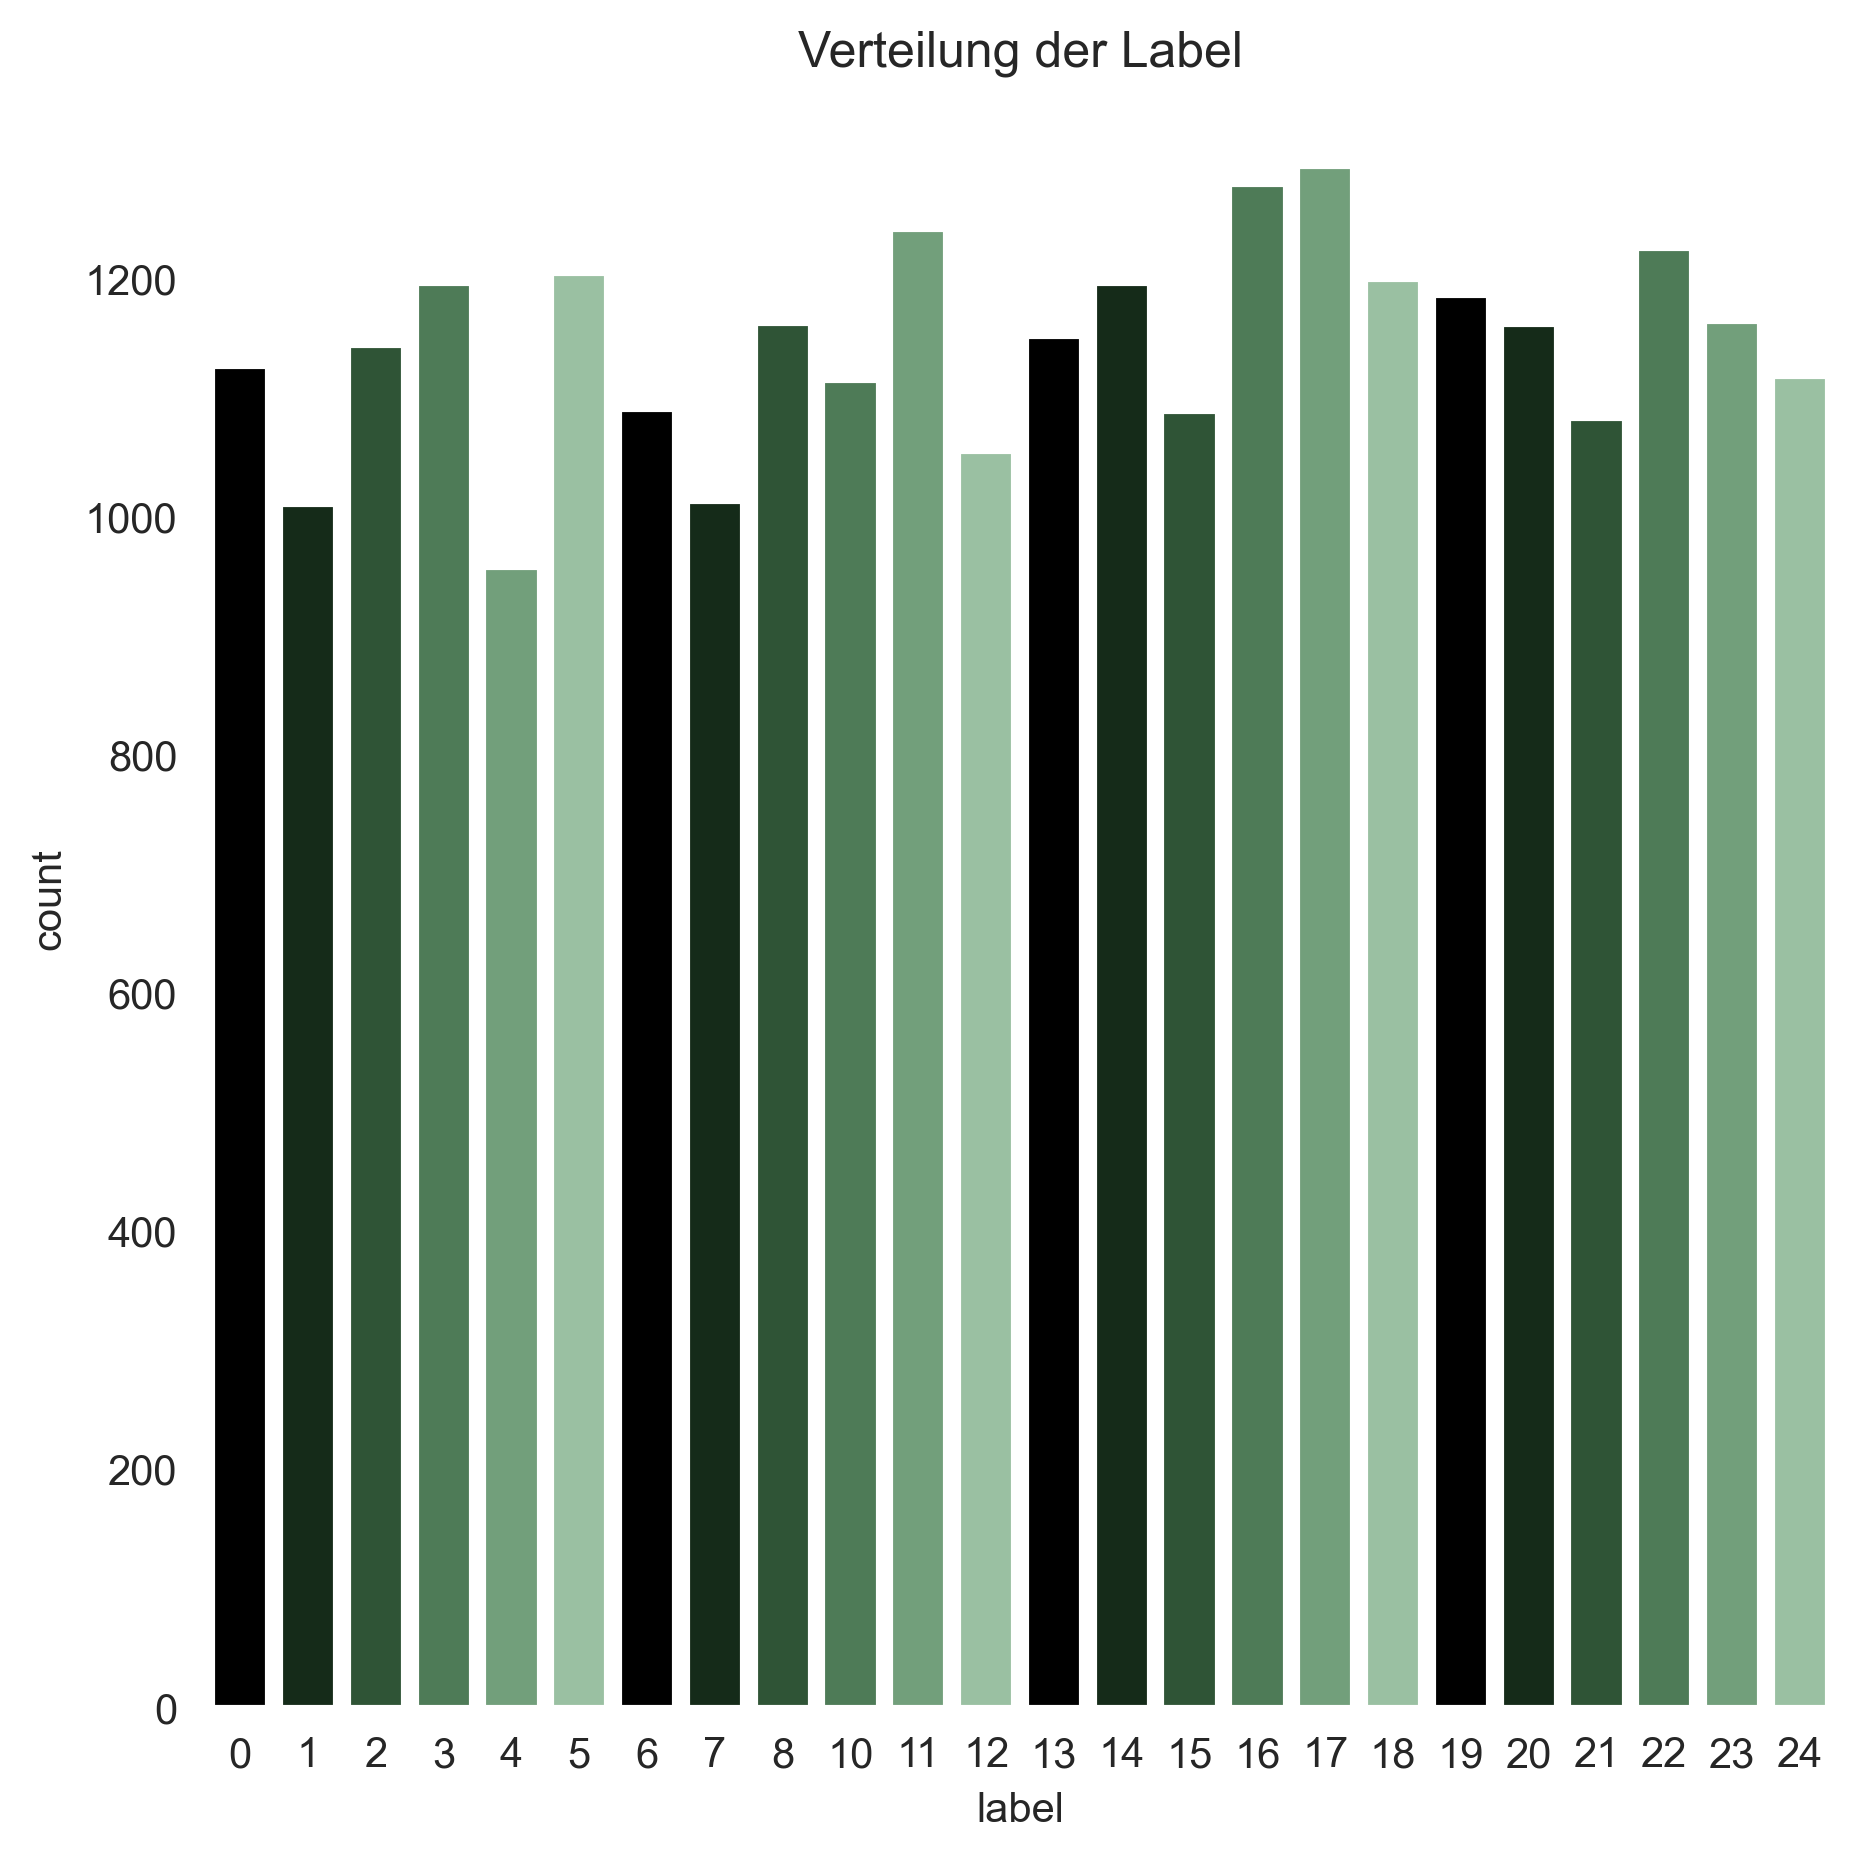

In [44]:
plt.figure(figsize = (7,7))
plt.rcParams['axes.facecolor'] = 'white'
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.70, reverse=True)


sns.countplot(x=train_df['label'], palette=cmap)
plt.title("Verteilung der Label")
plt.savefig(plot_path + "label_distribution" + output_format)

## Normalisierung des Datensatzes

Im Folgenden wird er Datensatz für die Verwendung zum Training des Machine Learning Models normalisiert.

In [45]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [46]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

x_train = train_df.values
x_test = test_df.values

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)


print("=" * 10 + " Ausgabe der Dimensionen der Datensätze " + "=" * 10 )
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print("=" * 10 + " Ausgabe der Dimensionen der Datensätze " + "=" * 10 )

========== Ausgabe der Dimensionen der Datensätze ==========
(27455, 28, 28, 1)
(27455, 24)
(7172, 28, 28, 1)
(7172, 24)
========== Ausgabe der Dimensionen der Datensätze ==========


## Image Generator

Erstellen eines Image Generators, welcher es uns erlaubt die Trainingsdaten zu verändern um so weitere Trainingsdaten zu generieren.

In [47]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## Model
Erstellen eines sequentiellen Machine Learning Models zur Klassifizierung der Bilder.

In [48]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_9 (Batc  (None, 28, 28, 75)       300       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 75)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 50)        33800     
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_10 (Bat  (None, 14, 14, 50)      

## Training
Der Summary ist zu entnehmen, dass das Model 263.749 trainierbare Parameter besitz. Im Folgenden wird das Modell trainiert, gesichert und der Trainingsverlauf in einer CSV Datei gespeichert. Sollte das Modell nicht neu trainiert werden sollen werden die Daten aus dem Cache geladen. Sollten diese nicht zu finden sein wird das Modell neu trainiert.

In [49]:
def training(my_model:Sequential):
    def train_model(model_to_train:Sequential):
        learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
        cache_history = model_to_train.fit(datagen.flow(x_train,y_train, batch_size = 128), epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])
        model.save(cache_path + model_name)
        cache_history = pd.DataFrame(cache_history.history)
        cache_history.to_csv(cache_path + training_history)

    if not retrain:
        try:
            check_model = load_model(cache_path + model_name)
            check_history = pd.read_csv(cache_path + training_history)
        except:
            print("Model konnte nicht geladen werden. Das Modell wir neu trainiert.")
            train_model(model_to_train=my_model)
    else:
        train_model(model_to_train=my_model)

training(model)

model = load_model(cache_path + model_name)
history = pd.read_csv(cache_path + training_history)

## Trainings Fortschritt

Der Trainingsfortschritt wird hier in 4 Plots dargestellt auf der einen Seite die Accuracy und auf der anderen Seite der Loss. Um besser zu erkennen wie sich die Accuracy und der Loss entwickelt wird der Trainingsfortschritt in den beiden unteren Plots noch einmal vergrößert dargestellt.

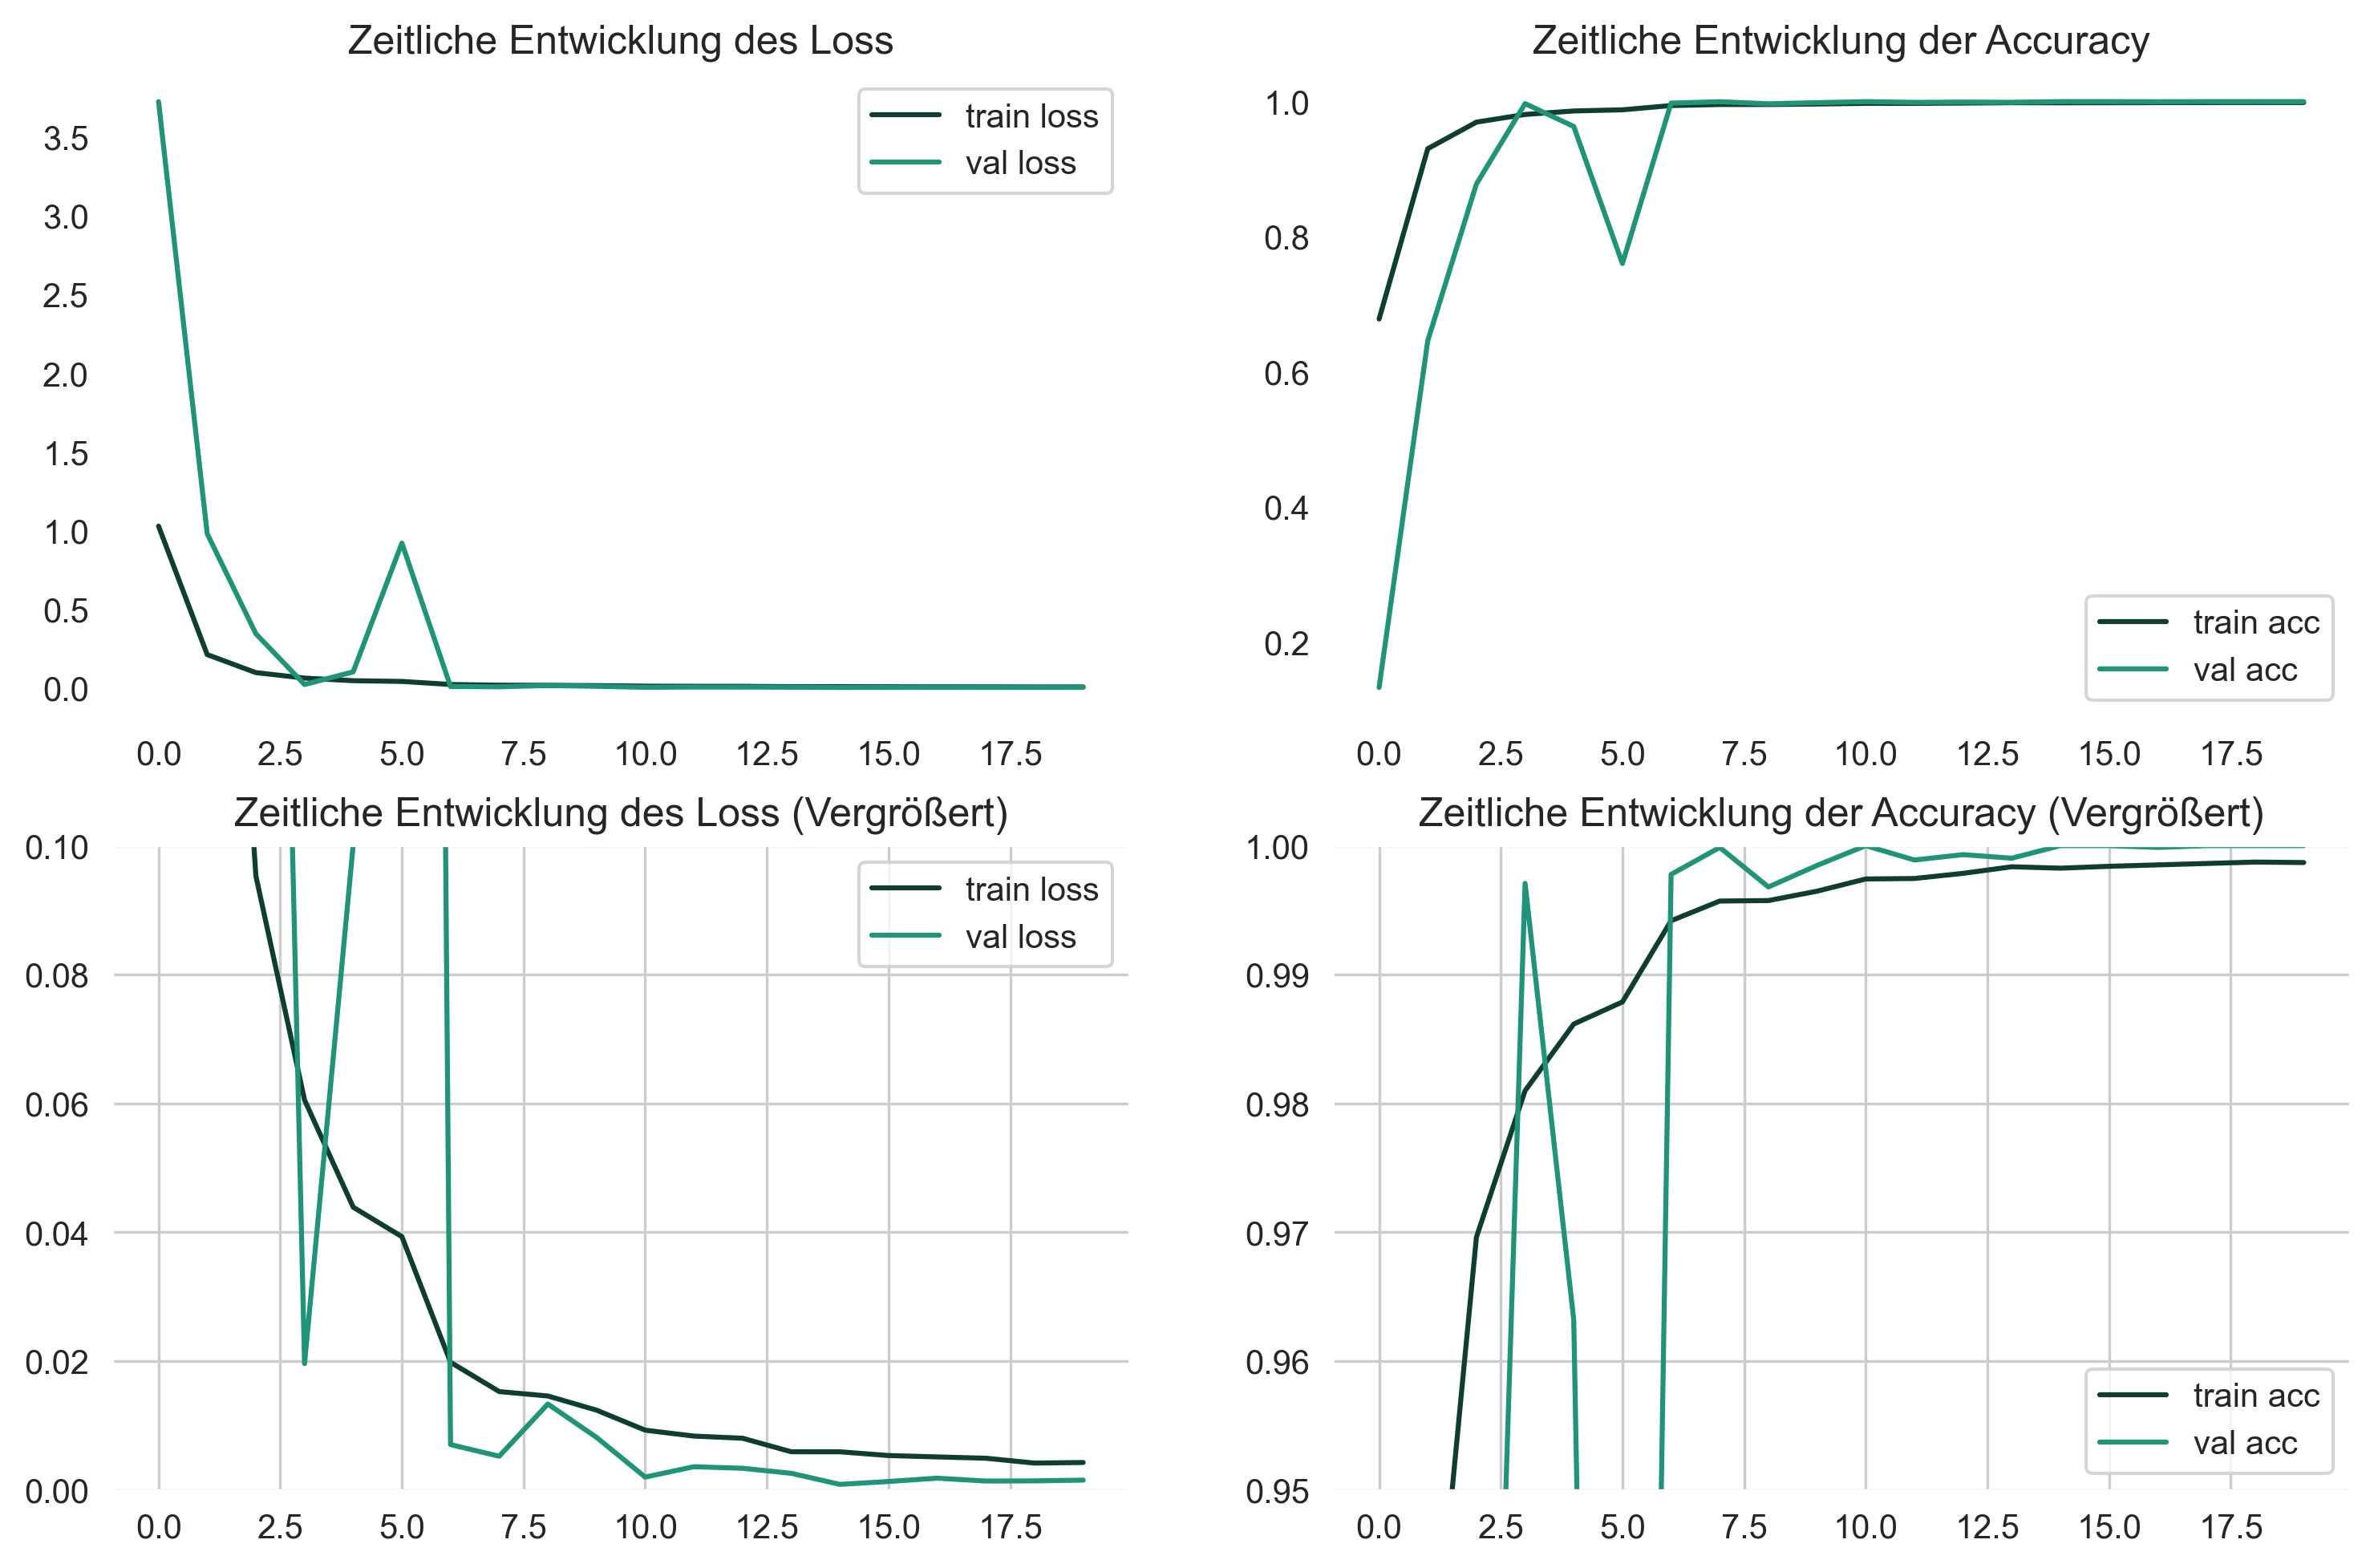

In [50]:
plt.figure(figsize=(12, 16))
c1= "#0E3E31"
c2 = "#209476"


plt.subplot(4, 2, 1)
plt.plot(history['loss'], label='train loss', color=c1)
plt.plot(history['val_loss'], label='val loss', color=c2)
plt.legend()
plt.title("Zeitliche Entwicklung des Loss")
plt.subplot(4, 2, 2)

plt.plot(history['accuracy'], label='train acc', color=c1)
plt.plot(history['val_accuracy'], label='val acc', color=c2)

plt.legend()
plt.title("Zeitliche Entwicklung der Accuracy")


plt.subplot(4, 2, 3)
plt.plot(history['loss'], label='train loss', color=c1)
plt.plot(history['val_loss'], label='val loss', color=c2)
plt.legend()
plt.ylim([0, 0.1])
plt.title("Zeitliche Entwicklung des Loss (Vergrößert)")
plt.grid(True, color='#CCCCCC')  # Change gridline color

plt.subplot(4, 2, 4)

plt.plot(history['accuracy'], label='train acc', color=c1)
plt.plot(history['val_accuracy'], label='val acc', color=c2)
plt.ylim([0.95, 1.0])
plt.legend()
plt.title("Zeitliche Entwicklung der Accuracy (Vergrößert)")
plt.grid(True, color='#CCCCCC')  # Change gridline color

plt.savefig(plot_path + "learning_curves"  + output_format)

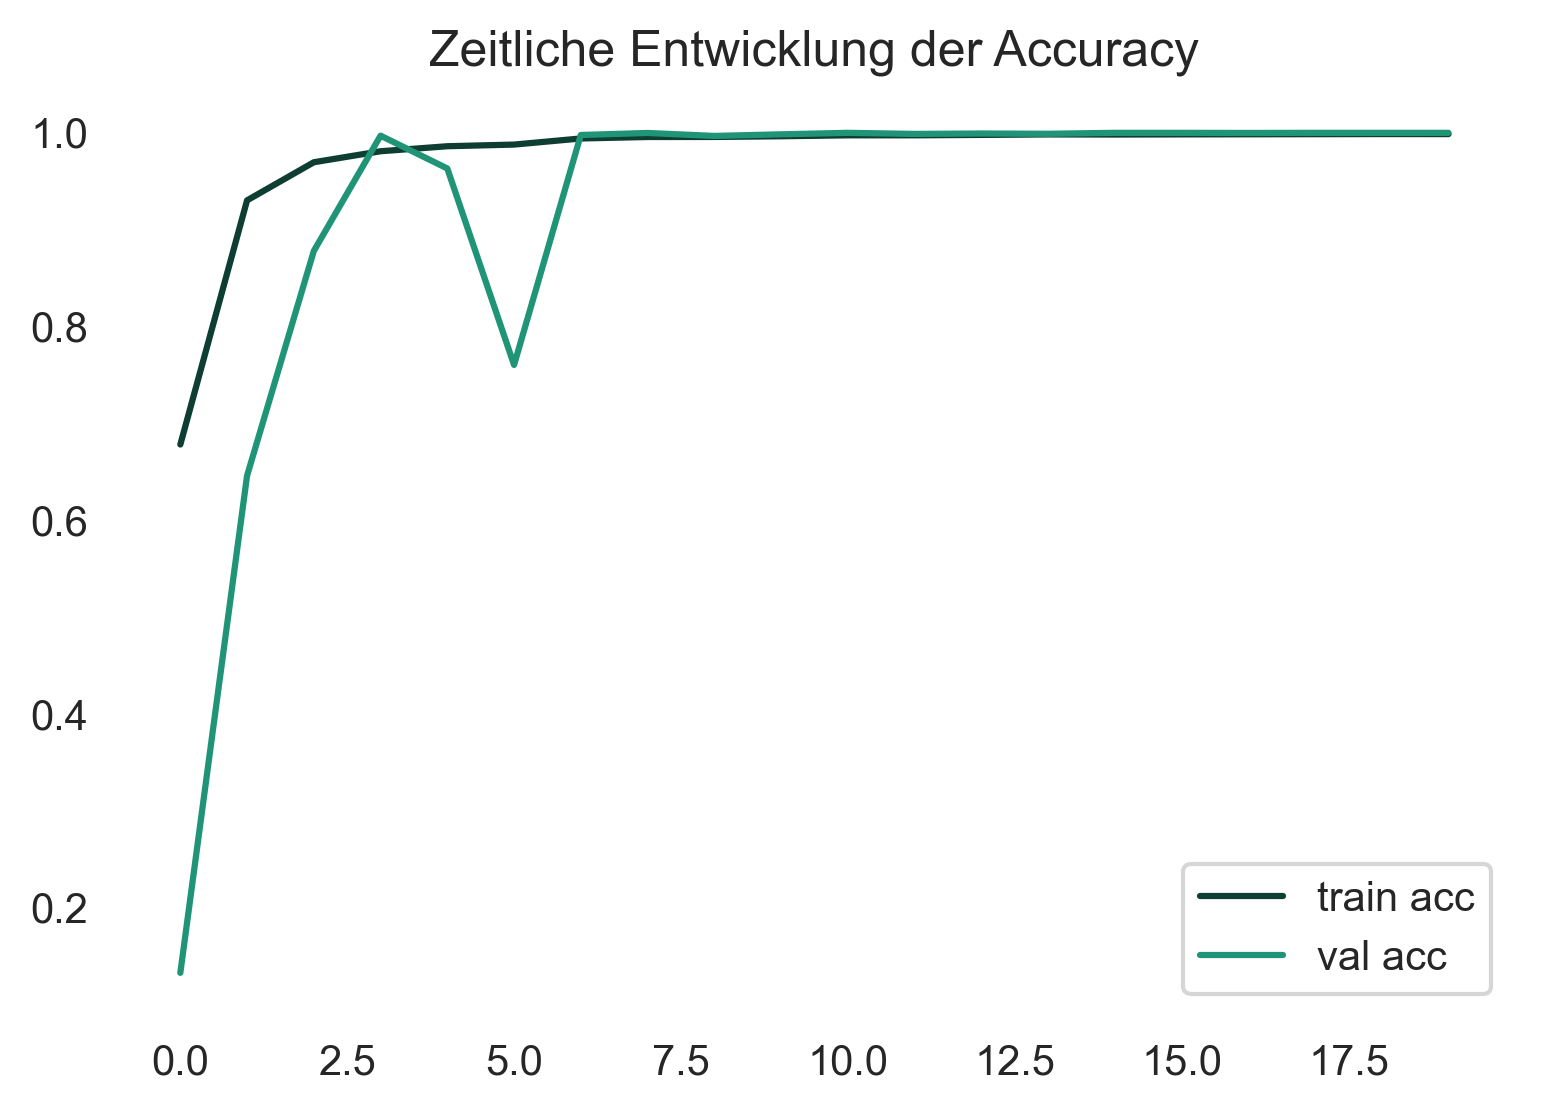

In [51]:
plt.figure(figsize=(6, 4))

plt.clf()
plt.plot(history['loss'], label='train loss', color=c1)
plt.plot(history['val_loss'], label='val loss', color=c2)
plt.legend()
plt.title("Zeitliche Entwicklung des Loss")
plt.savefig(plot_path + "loss_curve"  + output_format)

plt.clf()
plt.plot(history['accuracy'], label='train acc', color=c1)
plt.plot(history['val_accuracy'], label='val acc', color=c2)
plt.legend()
plt.title("Zeitliche Entwicklung der Accuracy")
plt.savefig(plot_path + "acc_curve"  + output_format)

## Evaluation
Die Evaluation des Modells erfolgt anhand der Testdaten. Hierbei wird die Accuracy und der Loss berechnet. Zusätzlich wird die Confusion Matrix berechnet und dargestellt.

In [52]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f"{'=' * 10} Evaluation of the Test Data {'=' * 10}")
print(f"n Training Samples: \t{train_num_samples}\nn Test Samples:\t\t\t{test_num_samples}")
print(f"Loss: \t\t\t\t\t{loss:.5f}\nAccuracy:\t\t\t\t{acc:.5f}")
print(f"{'=' * 10} Evaluation of the Test Data {'=' * 10}")

========== Evaluation of the Test Data ==========
n Training Samples: 	27455
n Test Samples:			7172
Loss: 					0.00155
Accuracy:				1.00000
========== Evaluation of the Test Data ==========


In [53]:
predictions = model.predict(x_test)
prediction_classes = np.argmax(predictions, axis=-1)

gt_classes = np.argmax(y_test, axis=-1)
confusion_matrix = metrics.confusion_matrix(gt_classes, prediction_classes)

225/225 [==============================] - 4s 19ms/step


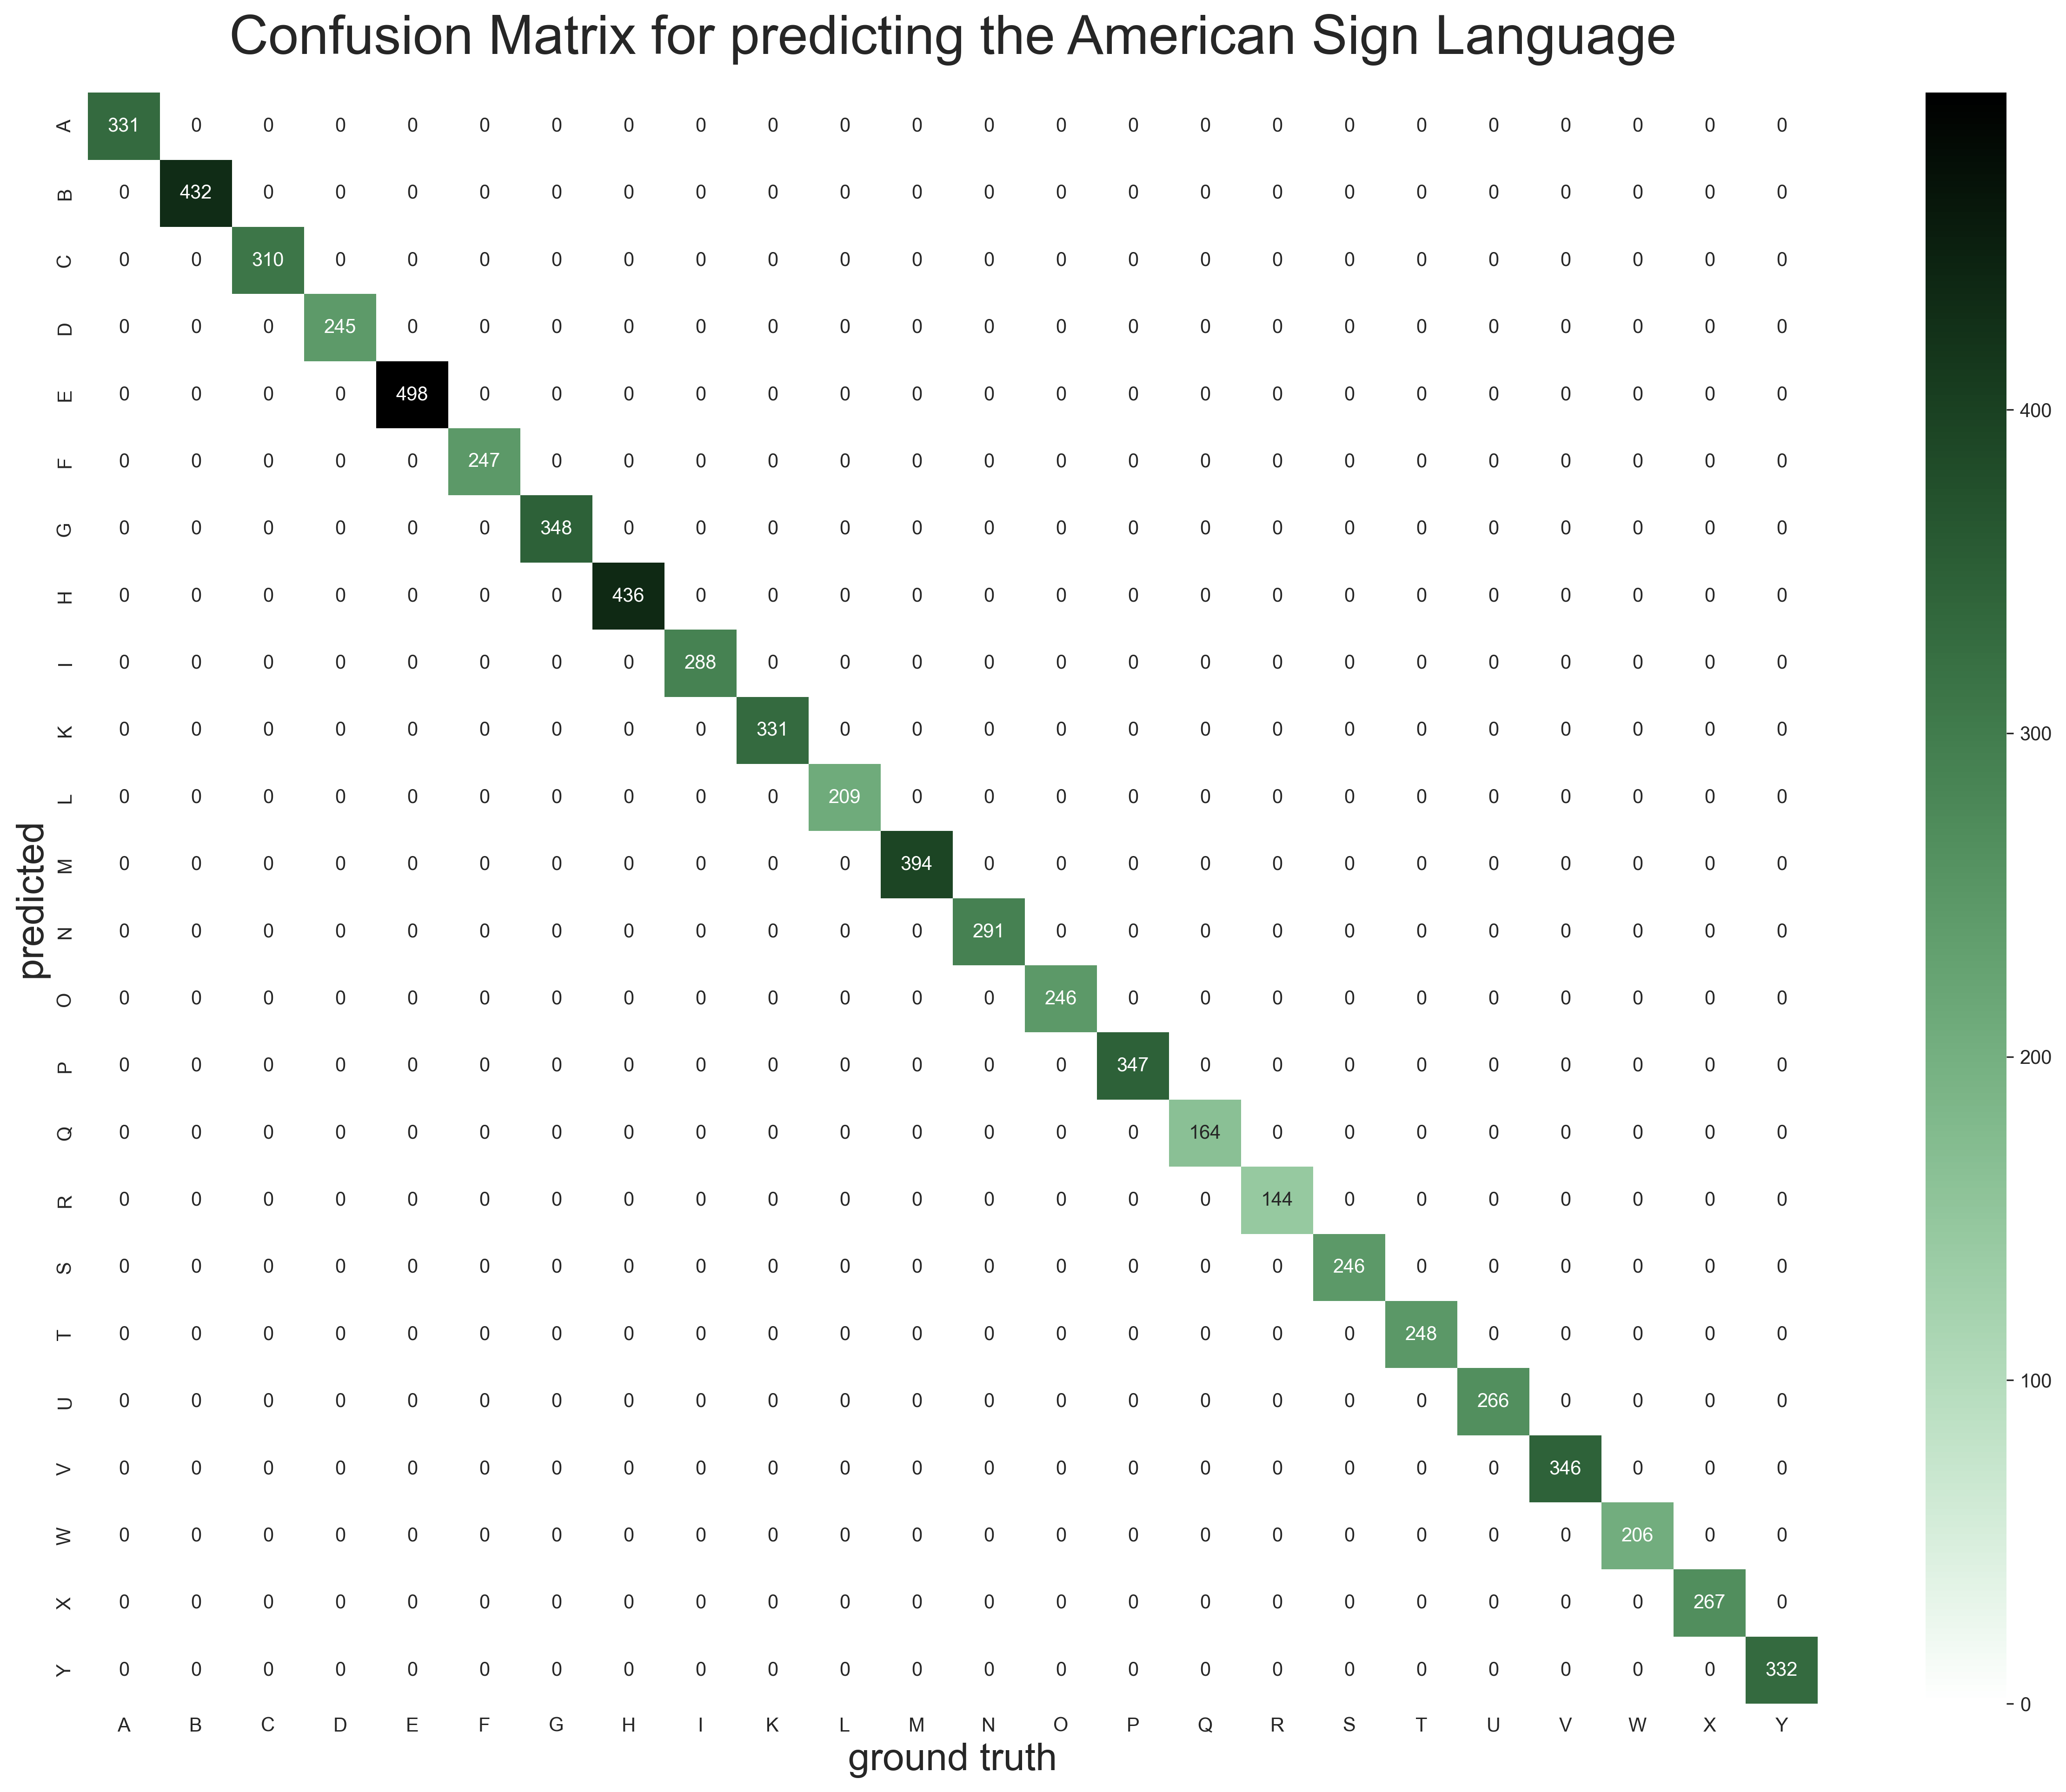

In [54]:
cmap = sns.cubehelix_palette(start=2, rot=0, dark=1, light=0, reverse=True, as_cmap=True)
sns.heatmap(pd.DataFrame(confusion_matrix, index=classes, columns=classes), annot=True, cmap=cmap, fmt='d')

plt.title('Confusion Matrix for predicting the American Sign Language', fontsize=28, pad=20)
plt.ylabel('predicted', fontsize=20)
plt.xlabel('ground truth', fontsize=20)
plt.savefig(plot_path + "confusion_matrix"  + output_format)
plt.show()

## Visualisierung der Vorhersagen
Im Folgenden werden die Vorhersagen des Modells visualisiert. Hierbei werden zufällig eine in der Variable amount_of_sample festgelegte Anzahl an Bildern aus dem Testdatensatz ausgewählt und mit der Vorhersage des Modells, sowie der tatsächlichen Wahrheit dargestellt.

In [55]:
amount_of_samples = 24 * 8


random.seed(3) # to make this deterministic
sample_indexes = random.sample(range(len(x_test)), amount_of_samples)
sample_images = [x_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

ground_truth = np.argmax(sample_labels, axis=1)

X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)

6/6 [==============================] - 0s 14ms/step


In [56]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels, export:bool = True):
    fig = plt.figure(figsize=(20, amount_of_samples +10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(amount_of_samples, 4,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(30, 10, f"Truth:           {classes[truth]}\nPrediction:   {classes[prediction]}",
                 fontsize=12, color=color)
        plt.imshow(images[i])
    if export:
        plt.savefig(plot_path + "predictions_many" + output_format)

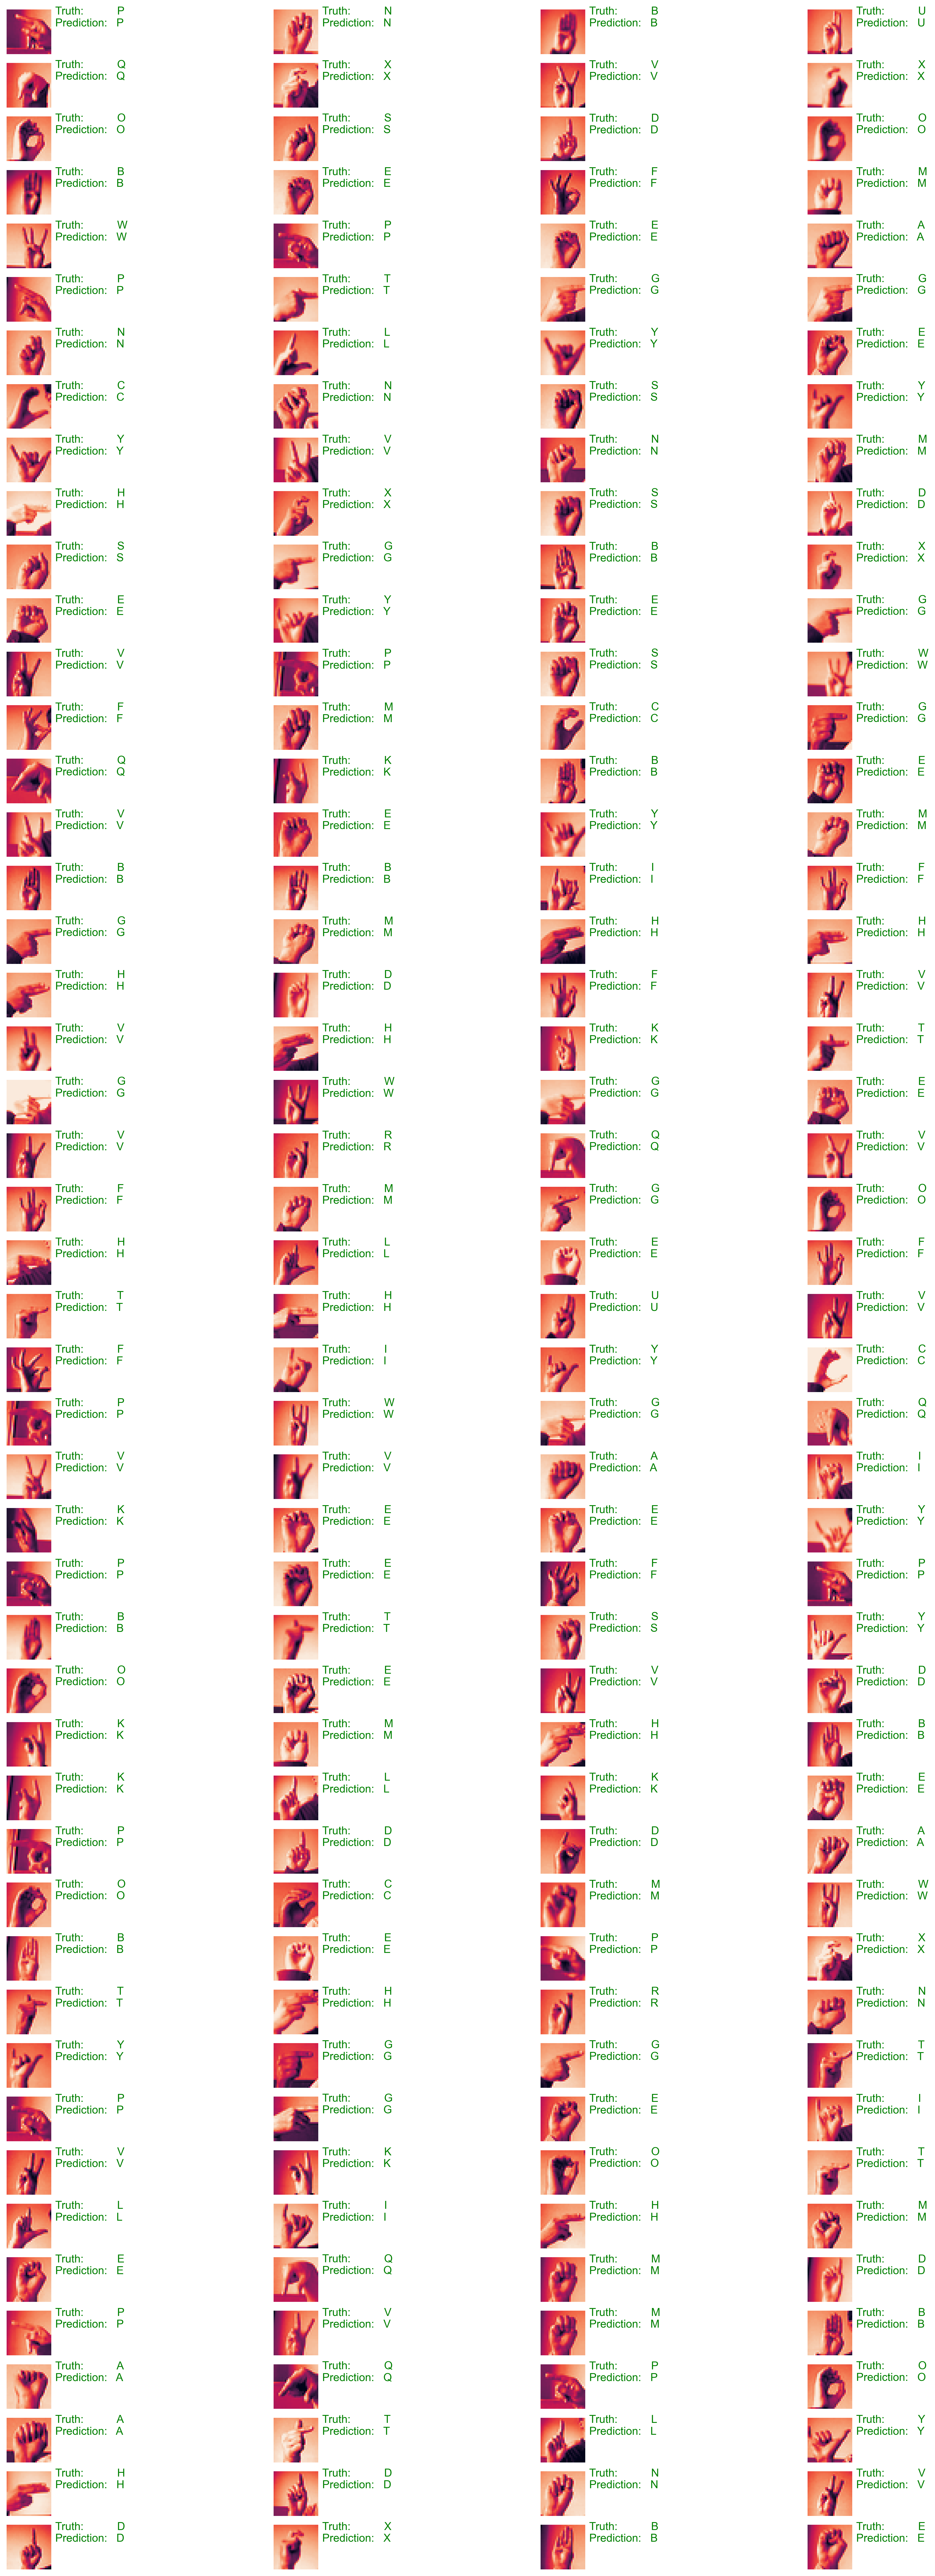

In [57]:
display_prediction(sample_images, ground_truth, predicted_categories)